In [1]:
# Package imports

import os.path as pth
import matplotlib.pyplot as plt # Matplotlib v3.5.1
import numpy as np # Numpy v1.23.4
import os
import json
import h5py
from typing import Union
import pandas as pd

from src.utils import set_rcParams

set_rcParams()

In [2]:
# Json file containing clusters informations

with open('clusters_informations_for_hybrid_simulations.json') as json_file:
    clusters_infos =  json.load(json_file)

In [3]:
# Functions used to read .mat results files

def generate_reduced_network_node_id_dict(clustered_nodes: list[int]) -> dict:
    """Generates dictionary to identify the remaining nodes from the original network nodes

    Args:
        clustered_nodes (list[int]): list of clustered nodes (in julia indexing)

    Returns:
        dict: dictionary to associate the original node id to the reduced network node ids
    """
    step = 0
    dict_ = {}
    for i in range(71): # There is 71 nodes in the case study network 1
        if (i+1) in clustered_nodes:
            step += 1
        dict_[i] = i-step
    return dict_

def prepocessing(dict_physical_values) -> dict:
    """Preprocess the read data from .mat files

    Args:
        dict_physical_values (dict): the dictionary from the mat file

    Returns:
        dict: the improved and treated dict file
    """
    dict_ = {}
    # Some prepocessing
    first_dynamic_step_interest = 10*60
    last_dynamic_steps_horizon = first_dynamic_step_interest + 2*7*24*60 - 1 # 1 week only for minute-time steps

    for physical_state_key in dict_physical_values:
        array = np.array(dict_physical_values[physical_state_key])
        if physical_state_key in ['trcs', 'mc']: # We take all for those
            dict_[physical_state_key] = array
        else:
            dict_[physical_state_key] = array[first_dynamic_step_interest:last_dynamic_steps_horizon,:]
    return dict_

def compute_mae_with_interval(distribution) -> tuple:
    """Computes the mean with interval confidence of 98%

    Args:
        distribution (numpy): the distribution

    Returns:
        tuple: (mean, +- confidence interval)
    """
    return np.mean(distribution), 1.96*np.std(distribution)/np.sqrt(len(distribution))

def get_hybrid_simulation_performances(scenario_dict_values: dict, model_key: str, clusters_keys:  Union[list[str],str], cluster_key_result: str = None, sources_to_consider=[0,56]) -> dict:
    """Reads the hybrid results and assess the reduced network simulation performances

    Args:
        scenario_dict_values (dict): the dictionary containing the scenario results including full physical and reduced networks
        model_key (str): the model considered [rnn, cnn]
        clusters_keys (Union[list[str],str]): the clusters keys
        cluster_key_result (str, optional): clusters key used for hybrid results name. Defaults to None.

    Raises:
        Exception: if cluster key not well defined

    Returns:
        dict: the dictionary of performances
    """
    incoming_pipes_ids = []
    incoming_pipes_ids_trout_nodes = []
    
    outgoing_pipes_ids = []
    outgoing_pipes_ids_tsout_nodes = []
    
    clustered_nodes = []
    associated_node_ids = dict()
    perfs = dict()
    
    if type(clusters_keys) == list:
        if cluster_key_result == None:
            raise Exception('Cluster key result must be defined for many clusters considered')
        for key in clusters_keys:
            cluster_info = clusters_infos[f'cluster_{key}']
            # print(cluster_info)
            incoming_pipes_ids.extend(cluster_info['incoming_pipes_id'])
            incoming_pipes_ids_trout_nodes.extend(cluster_info['incoming_pipes_remixing_node_id'])
            outgoing_pipes_ids.extend(cluster_info['outgoing_pipe_id'])
            outgoing_pipes_ids_tsout_nodes.extend(cluster_info['outgoing_pipe_remixing_node_id'])
            clustered_nodes.extend(cluster_info['cluster_nodes'])

        associated_node_ids = generate_reduced_network_node_id_dict(clustered_nodes)
        key = cluster_key_result # key to identify dict of results
        
    else:
        key = clusters_keys
        cluster_info = clusters_infos[f'cluster_{key}']
        # print(cluster_info)
        incoming_pipes_ids.extend(cluster_info['incoming_pipes_id'])
        incoming_pipes_ids_trout_nodes.extend(cluster_info['incoming_pipes_remixing_node_id'])
        outgoing_pipes_ids.extend(cluster_info['outgoing_pipe_id'])
        outgoing_pipes_ids_tsout_nodes.extend(cluster_info['outgoing_pipe_remixing_node_id'])
        clustered_nodes.extend(cluster_info['cluster_nodes'])
        associated_node_ids = generate_reduced_network_node_id_dict(cluster_info['cluster_nodes'])

    perfs['key'] = key
    perfs['type'] = cluster_info['cluster_type']
    perfs['clustered_nodes_number'] = len(clustered_nodes)
    perfs['clustered_nodes_percentage'] = 100*(len(clustered_nodes) / 71)
    perfs['clustered_pipes_percentage'] = 100*((len(clustered_nodes)+len(outgoing_pipes_ids)) / 71) # Tree-like assumption => number of nodes == number edges
    
    loads_mare_f = []
    
    for i, el in enumerate(incoming_pipes_ids):
        el_i = incoming_pipes_ids_trout_nodes[i]
        pipe_index = int(el)-1 # Ingoing pipe index in the original network (needed for effective comparison) !! -1 as julia are indexed from 1
        node_index = int(el_i)-1 # Adjacent nodes to the cluster (in the return direction) !! -1 as julia are indexed from 1

        mw = np.abs(np.mean(scenario_dict_values['full_physic']['mw'][:,pipe_index]))
        # print(f'Original incoming pipe (scenario) {el} traversed by mass flow rates with nominal value of {mw:.2f} Kg/s')

        tr_node_mix = scenario_dict_values['full_physic']['tr'][:,node_index]
        ts_node_mix = scenario_dict_values['full_physic']['ts'][:,node_index]
            
        tr_node_mix_reduced = scenario_dict_values[model_key][key]['tr'][:,associated_node_ids[node_index]]
        ts_node_mix_reduced = scenario_dict_values[model_key][key]['ts'][:,associated_node_ids[node_index]]
        
        pw_adj_node = mw*4200*(ts_node_mix-tr_node_mix)
        pw_adj_node_reduced = mw*4200*(ts_node_mix_reduced-tr_node_mix_reduced)
        
        loads_mare_f.extend(100*(np.abs(1 - pw_adj_node_reduced/pw_adj_node)))
        
    for i, el in enumerate(outgoing_pipes_ids):
        el_i = outgoing_pipes_ids_tsout_nodes[i]
        pipe_index = int(el)-1
        node_index = int(el_i)-1
        
        mw = np.abs(np.mean(scenario_dict_values['full_physic']['mw'][:,pipe_index]))

        tr_node_mix = scenario_dict_values['full_physic']['tr'][:,node_index]
        ts_node_mix = scenario_dict_values['full_physic']['ts'][:,node_index]
        tr_node_mix_reduced = scenario_dict_values[model_key][key]['tr'][:,associated_node_ids[node_index]]
        ts_node_mix_reduced = scenario_dict_values[model_key][key]['ts'][:,associated_node_ids[node_index]]
        
        pw_adj_node = mw*4200*(ts_node_mix-tr_node_mix)
        pw_adj_node_reduced = mw*4200*(ts_node_mix_reduced-tr_node_mix_reduced)
        
        loads_mare_f.extend(100*(np.abs(1 - pw_adj_node_reduced/pw_adj_node)))
        

    mare_f, conf_f = compute_mae_with_interval(loads_mare_f)
    
    perfs['Thermal loads (MARE)'] = mare_f
    perfs['Thermal loads (MARE-Conf_interval)'] = conf_f
    perfs['Thermal loads (errors)'] = loads_mare_f
        
    tr_node_source_f = scenario_dict_values['full_physic']['tr'][:,sources_to_consider].reshape(1,-1)
    ts_node_source_f = scenario_dict_values['full_physic']['ts'][:,sources_to_consider].reshape(1,-1)
    
    associated_sources_nodes_ids = [associated_node_ids[i] for i in sources_to_consider]
    tr_node_source_reduced_f = scenario_dict_values[model_key][key]['tr'][:,associated_sources_nodes_ids].reshape(1,-1)
    ts_node_source_reduced_f = scenario_dict_values[model_key][key]['ts'][:,associated_sources_nodes_ids].reshape(1,-1)

    mw_source_node_f = scenario_dict_values['full_physic']['mw'][:,sources_to_consider].reshape(1,-1)
    
    pw_adj_node_f = mw_source_node_f*4200*(ts_node_source_f-tr_node_source_f)
    pw_adj_node_reduced_f = mw_source_node_f*4200*(ts_node_source_reduced_f-tr_node_source_reduced_f)
    
    mae_r_f, conf_r_f = compute_mae_with_interval(np.abs(tr_node_source_f-tr_node_source_reduced_f))
    # print(f'Source return temperature conservation (scenario) MAE = {mae_r_f:.4f} °C +- {conf_r_f:.4f}') 
    perfs['Source return temp (MAE)'] = mae_r_f
    perfs['Source return temp (MAE-Conf_interval)'] = conf_r_f
    perfs['Source return temp (errors)'] = np.abs(tr_node_source_f-tr_node_source_reduced_f)

    mare_pw_f, conf_pw_f = compute_mae_with_interval(100*np.abs(1 - pw_adj_node_reduced_f/pw_adj_node_f))
    # print(f'Source generation power conservation (scenario) MARE = {mare_pw_f:.4f} % +- {conf_pw_f:.4f}') 
    perfs['Source gen (MARE)'] = mare_pw_f
    perfs['Source gen (MARE-Conf_interval)'] = conf_pw_f
    perfs['Source gen (errors)'] = 100*np.abs(1 - pw_adj_node_reduced_f/pw_adj_node_f)
    
    return perfs


In [4]:
# Scenario 1 

folder = os.path.join('ARTICLE_hybrid_results')
first_scenario_results = {}
# Note: non present values are extrapolated
# Les demandes ne sont pas modifiés trop dont utiliser l'autre 
# 1st scenario == ts var mais demandes differentes

# I call it large clusters because I create them for the non present clusters at the begining
# but I end up redoing some "normal" clusters leading v2 results 
# similar to v1 but I am afraid that some values might have change so compare physical v2 with reduced v2 to obtain the results

full_network_physical_file_path = os.path.join(folder, 'original_large_clusters_scenario_1.mat')
first_scenario_results['full_physic'] = h5py.File(full_network_physical_file_path, 'r') # Dict ['load', 'mc', 'mw', 'topology_load', 'tr', 'trcs', 'trin', 'trout', 'ts', 'tsin', 'tsout']
first_scenario_results['full_physic'] = prepocessing(first_scenario_results['full_physic'])

first_scenario_results['rnn'] = {}
first_scenario_results['cnn'] = {}

perfs_per_models = {}
perfs_per_models['rnn'] = {}
perfs_per_models['cnn'] = {}

folder_scenario_1 = 'scenario_1_results'
if not os.path.isdir(folder_scenario_1):
    os.mkdir(folder_scenario_1)

import json
import pickle 

with open(os.path.join(folder_scenario_1, f'results_full_network_v2.pkl'), 'wb') as f:
    pickle.dump(first_scenario_results['full_physic'], f)

for key in ['g', 'manual_1', 'g_manual_1', 'i', 'm', 'f_manual_1']:
    for model in ['rnn', 'cnn']:
        try:
            reduced_file_path_rnn = os.path.join(folder, f'hybrid_{key}_scenario_1_model_{model}.mat')
            dict_values = h5py.File(reduced_file_path_rnn, 'r')
            first_scenario_results[model][key] = prepocessing(dict_values)
            if key == 'f_manual_1':
                sources = [0,56] # can add '56'
                perfs_per_models[model][key] = get_hybrid_simulation_performances(first_scenario_results, model, ['f','manual_1'], cluster_key_result='f_manual_1', sources_to_consider=sources)
            elif key == 'g_manual_1':
                sources = [0,56] # can add '56'
                perfs_per_models[model][key] = get_hybrid_simulation_performances(first_scenario_results, model, ['g','manual_1'], cluster_key_result='g_manual_1', sources_to_consider=sources)
            else:
                sources = [0] # can add '56'
                perfs_per_models[model][key] = get_hybrid_simulation_performances(first_scenario_results, model, key, cluster_key_result=key, sources_to_consider=sources)
            
            with open(os.path.join(folder_scenario_1, f'results_{model}_{key}_v2.pkl'), 'wb') as f:
                pickle.dump(perfs_per_models[model][key], f)
            
        except Exception as ex:
            print(ex)

[Errno 2] Unable to synchronously open file (unable to open file: name = 'ARTICLE_hybrid_results\hybrid_g_scenario_1_model_cnn.mat', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
[Errno 2] Unable to synchronously open file (unable to open file: name = 'ARTICLE_hybrid_results\hybrid_manual_1_scenario_1_model_cnn.mat', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
[Errno 2] Unable to synchronously open file (unable to open file: name = 'ARTICLE_hybrid_results\hybrid_g_manual_1_scenario_1_model_cnn.mat', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
[Errno 2] Unable to synchronously open file (unable to open file: name = 'ARTICLE_hybrid_results\hybrid_i_scenario_1_model_cnn.mat', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
[Errno 2] Unable to synchronously open file (unable to open file: name = 'ARTICLE_hybrid_results\hybrid_m_scenario_1_model_cnn.mat',

In [8]:
# Scenario 2

folder = os.path.join('ARTICLE_hybrid_results')
second_scenario_results = {}
# Note: non present values are extrapolated
# Les demandes ne sont pas modifiés trop dont utiliser l'autre 
# 1st scenario == ts var mais demandes differentes

full_network_physical_file_path = os.path.join(folder, 'original_large_clusters_scenario_2.mat')
second_scenario_results['full_physic'] = h5py.File(full_network_physical_file_path, 'r') # Dict ['load', 'mc', 'mw', 'topology_load', 'tr', 'trcs', 'trin', 'trout', 'ts', 'tsin', 'tsout']
second_scenario_results['full_physic'] = prepocessing(second_scenario_results['full_physic'])

second_scenario_results['rnn'] = {}
second_scenario_results['cnn'] = {}

perfs_per_models = {}
perfs_per_models['rnn'] = {}
perfs_per_models['cnn'] = {}

folder_scenario_2 = 'scenario_2_results'
if not os.path.isdir(folder_scenario_2):
    os.mkdir(folder_scenario_2)

import json
import pickle 

with open(os.path.join(folder_scenario_2, f'results_full_network_v2.pkl'), 'wb') as f:
    pickle.dump(second_scenario_results['full_physic'], f)

for key in ['g', "e", 'manual_1', 'g_manual_1', 'i', 'm', 'f_manual_1']:
    for model in ['rnn', 'cnn']:
        try:
            reduced_file_path_rnn = os.path.join(folder, f'hybrid_{key}_scenario_2_model_{model}.mat')
            dict_values = h5py.File(reduced_file_path_rnn, 'r')
            second_scenario_results[model][key] = prepocessing(dict_values)
            if key == 'f_manual_1':
                sources = [0,56] # can add '56'
                perfs_per_models[model][key] = get_hybrid_simulation_performances(second_scenario_results, model, ['f','manual_1'], cluster_key_result='f_manual_1', sources_to_consider=sources)
            elif key == 'g_manual_1':
                sources = [0,56] # can add '56'
                perfs_per_models[model][key] = get_hybrid_simulation_performances(second_scenario_results, model, ['g','manual_1'], cluster_key_result='g_manual_1', sources_to_consider=sources)
            else:
                sources = [0] # can add '56'
                perfs_per_models[model][key] = get_hybrid_simulation_performances(second_scenario_results, model, key, cluster_key_result=key, sources_to_consider=sources)
            
            with open(os.path.join(folder_scenario_2, f'results_{model}_{key}_v2.pkl'), 'wb') as f:
                pickle.dump(perfs_per_models[model][key], f)
            
        except Exception as ex:
            print(ex)

[Errno 2] Unable to synchronously open file (unable to open file: name = 'ARTICLE_hybrid_results\hybrid_e_scenario_2_model_cnn.mat', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
[Errno 2] Unable to synchronously open file (unable to open file: name = 'ARTICLE_hybrid_results\hybrid_manual_1_scenario_2_model_rnn.mat', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
[Errno 2] Unable to synchronously open file (unable to open file: name = 'ARTICLE_hybrid_results\hybrid_manual_1_scenario_2_model_cnn.mat', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
[Errno 2] Unable to synchronously open file (unable to open file: name = 'ARTICLE_hybrid_results\hybrid_g_manual_1_scenario_2_model_rnn.mat', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
[Errno 2] Unable to synchronously open file (unable to open file: name = 'ARTICLE_hybrid_results\hybrid_g_manual_1_scenario_2

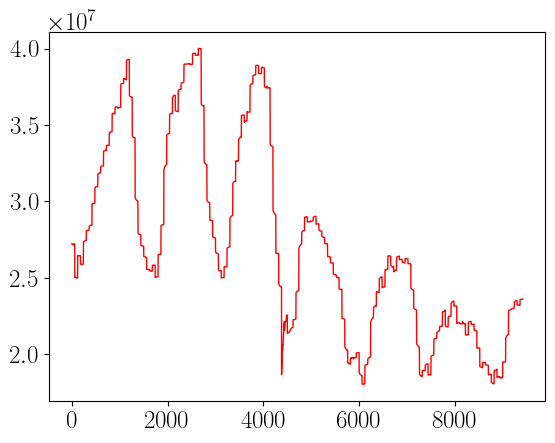

In [11]:
plt.plot(np.sum(second_scenario_results['full_physic']['load'], axis=1))
# plt.plot(second_scenario_results['rnn']['b']['tr'][:,0])
# print(100*np.mean(np.abs(1 - second_scenario_results['rnn']['b']['tr'][:,0]/second_scenario_results['full_physic']['tr'][:,0])))

In [10]:
perfs_per_models['rnn']['e']['Source gen (MARE)'] # verifying

0.01387191964811614

In [23]:
# Scenario 2

folder = os.path.join('ARTICLE_hybrid_results')
first_scenario_results = {}
# Note: non present values are extrapolated
# Les demandes ne sont pas modifiés trop dont utiliser l'autre 
# 1st scenario == ts var mais demandes differentes

full_network_physical_file_path = os.path.join(folder, 'original_large_clusters_scenario_2_scenario_2.mat')
first_scenario_results['full_physic'] = h5py.File(full_network_physical_file_path, 'r') # Dict ['load', 'mc', 'mw', 'topology_load', 'tr', 'trcs', 'trin', 'trout', 'ts', 'tsin', 'tsout']
first_scenario_results['full_physic'] = prepocessing(first_scenario_results['full_physic'])


reduced_file_path_rnn = os.path.join(folder, f'hybrid_m_scenario_2_model_rnn.mat')
dict_values = h5py.File(reduced_file_path_rnn, 'r')
first_scenario_results['rnn'] = {}
first_scenario_results['rnn']['m'] = prepocessing(dict_values)

reduced_file_path_rnn = os.path.join(folder, f'hybrid_m_scenario_2_model_cnn.mat')
dict_values = h5py.File(reduced_file_path_rnn, 'r')
first_scenario_results['cnn'] = {}
first_scenario_results['cnn']['m'] = prepocessing(dict_values)

sources = [0] # can add '56'
perfs_per_models = {}
perfs_per_models['rnn'] = {}
perfs_per_models['cnn'] = {}
perfs_per_models['rnn']['m'] = get_hybrid_simulation_performances(first_scenario_results, 'rnn', 'm', cluster_key_result='m', sources_to_consider=sources)
perfs_per_models['cnn']['m'] = get_hybrid_simulation_performances(first_scenario_results, 'cnn', 'm', cluster_key_result='m', sources_to_consider=sources)